In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (skip metadata rows)
df = pd.read_csv("../data/oil_prices.csv", skiprows=4)

# Rename columns
df.columns = ['Date', 'Price']

# Convert and clean
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.dropna(inplace=True)
# Quick check
df.head()


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


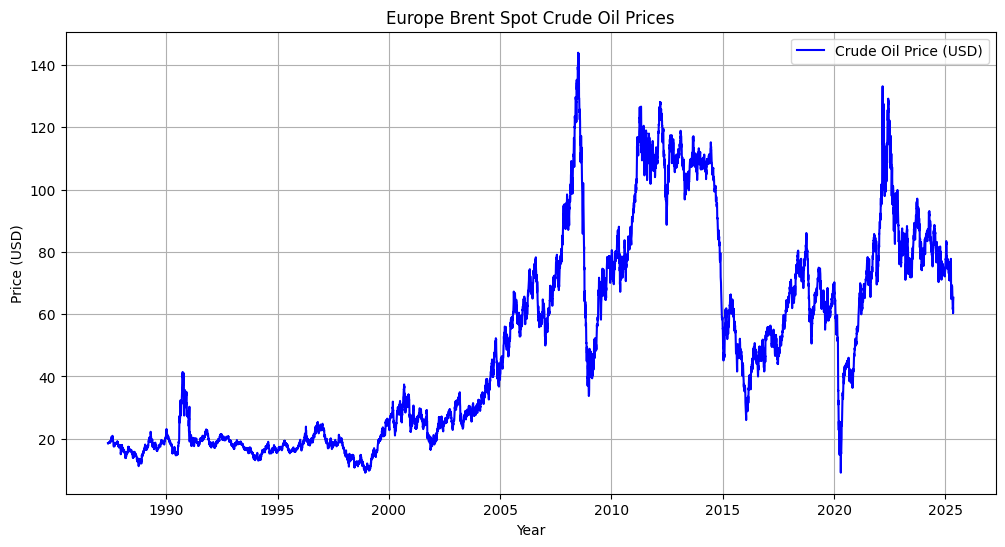

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Crude Oil Price (USD)', color='blue')
plt.title("Europe Brent Spot Crude Oil Prices")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.savefig('../oil_prices_trend.png')  # For your README later
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Split: 80% train, 20% test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Reset index to avoid misalignment issues
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 7708
Test size: 1928


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Train ARIMA model
model_arima = ARIMA(train['Price'], order=(5,1,0))
results_arima = model_arima.fit()

# Forecast for the test period
forecast_arima = results_arima.get_forecast(steps=len(test))
arima_preds = forecast_arima.predicted_mean

# Reset index for alignment
arima_preds = arima_preds.reset_index(drop=True)
test_clean = test['Price'].reset_index(drop=True)

# Drop any rows where either prediction or actual is NaN
combined = pd.concat([test_clean, arima_preds], axis=1)
combined.columns = ['actual', 'predicted']
combined = combined.dropna()

# Evaluate
arima_rmse = np.sqrt(mean_squared_error(combined['actual'], combined['predicted']))
print(f"ARIMA RMSE: {arima_rmse:.2f}")


ARIMA RMSE: 22.97


In [5]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

prophet_df = df.reset_index()[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df[:train_size]
test_prophet = prophet_df[train_size:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test_prophet))
forecast = model_prophet.predict(future)

prophet_preds = forecast[['ds', 'yhat']].iloc[-len(test_prophet):].reset_index(drop=True)
actual_test = test_prophet['y'].reset_index(drop=True)

# Drop NaNs from both sides
combined = pd.concat([actual_test, prophet_preds['yhat']], axis=1).dropna()
actual_clean = combined.iloc[:, 0]
preds_clean = combined.iloc[:, 1]

prophet_rmse = np.sqrt(mean_squared_error(actual_clean, preds_clean))
print(f"Prophet RMSE: {prophet_rmse:.2f}")

20:10:19 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 82.23


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Use only the 'Price' column
lstm_data = df[['Price']].copy()

# Scale the data to range (0,1)
scaler = MinMaxScaler()
lstm_scaled = scaler.fit_transform(lstm_data)

# Define a function to create sequences
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 60
X_all, y_all = create_sequences(lstm_scaled, seq_length)

# Split into train and test (same 80/20 split)
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]


In [8]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


D:\Oil-Price-Forecasting\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0113
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9383e-04
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.4744e-04
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2512e-04
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1650e-04
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0085e-04
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8090e-04
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5538e-04
Epoch 9/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4809e-04
Epoch 10/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4724e-04


In [9]:
lstm_preds = model_lstm.predict(X_test)

# Inverse scale both predicted and actual values
lstm_preds_unscaled = scaler.inverse_transform(lstm_preds)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [10]:
from sklearn.metrics import mean_squared_error

# Flatten and clean
y_test_clean = y_test_unscaled.flatten()
lstm_preds_clean = lstm_preds_unscaled.flatten()

# Remove any NaNs (just in case)
mask = ~np.isnan(y_test_clean) & ~np.isnan(lstm_preds_clean)
y_test_clean = y_test_clean[mask]
lstm_preds_clean = lstm_preds_clean[mask]

# Compute RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test_clean, lstm_preds_clean))
print(f"LSTM RMSE: {lstm_rmse:.2f}")

LSTM RMSE: 2.72


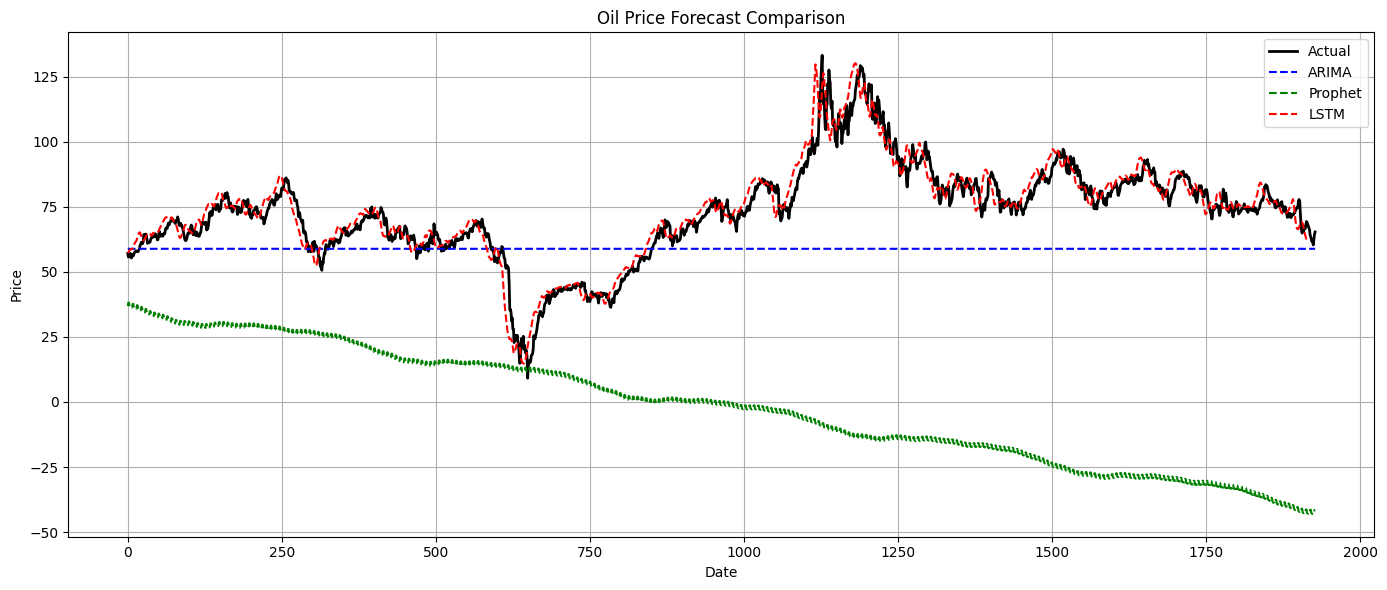

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 6))

# Actual test values (same across models)
plt.plot(test.index, test['Price'], label='Actual', color='black', linewidth=2)

# ARIMA predictions
plt.plot(test.index[:len(arima_preds)], arima_preds, label='ARIMA', linestyle='--', color='blue')

# Prophet predictions (assumes test_prophet is aligned with test)
plt.plot(test.index[:len(prophet_preds)], prophet_preds['yhat'], label='Prophet', linestyle='--', color='green')

# LSTM predictions
plt.plot(test.index[:len(lstm_preds_clean)], lstm_preds_clean, label='LSTM', linestyle='--', color='red')

plt.title("Oil Price Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()